In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
import itertools
from tqdm import tqdm
from copy import copy, deepcopy

In [2]:
transactions = pd.read_csv('./CSVs/transactions.csv')
transactions.drop(columns = ['Unnamed: 0'],inplace=True)
transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Hour,Sales,Frequency,total_product_purchases,category,sub_category,full_categ
0,536365,85123a,white hanging heart tlight holder,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,1,8,15.30,35,122.0,heart,holder,holder heart
1,536373,85123a,white hanging heart tlight holder,6.0,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,12,1,9,15.30,35,122.0,heart,holder,holder heart
2,536375,85123a,white hanging heart tlight holder,6.0,2010-12-01 09:32:00,2.55,17850.0,United Kingdom,12,1,9,15.30,35,122.0,heart,holder,holder heart
3,536396,85123a,white hanging heart tlight holder,6.0,2010-12-01 10:51:00,2.55,17850.0,United Kingdom,12,1,10,15.30,35,122.0,heart,holder,holder heart
4,536406,85123a,white hanging heart tlight holder,8.0,2010-12-01 11:33:00,2.55,17850.0,United Kingdom,12,1,11,20.40,35,122.0,heart,holder,holder heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525624,581578,22993,set of 4 pantry jelly moulds,12.0,2011-12-09 12:16:00,1.25,12713.0,Germany,12,9,12,15.00,1,12.0,pantry,other,other pantry
525625,581578,22907,pack of 20 napkins pantry design,12.0,2011-12-09 12:16:00,0.85,12713.0,Germany,12,9,12,10.20,1,12.0,pack,pantry,pantry pack
525626,581578,22908,pack of 20 napkins red apples,12.0,2011-12-09 12:16:00,0.85,12713.0,Germany,12,9,12,10.20,1,12.0,pack,napkins,napkins pack
525627,581578,23215,jingle bell heart antique silver,12.0,2011-12-09 12:16:00,2.08,12713.0,Germany,12,9,12,24.96,1,12.0,heart,silver,silver heart


Proportion of train events: 0.72


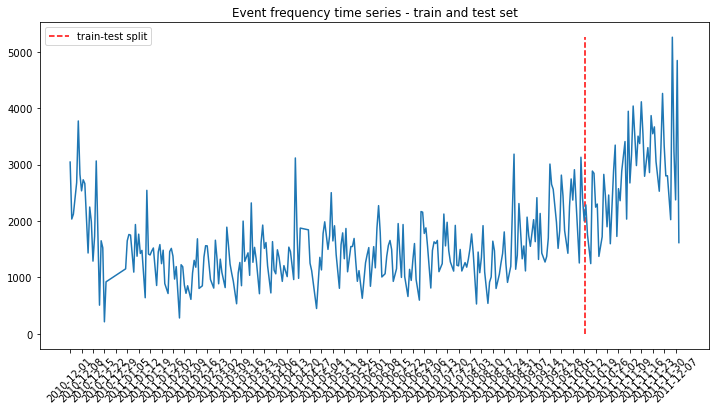

In [3]:
# Train-test split
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'])
start_train = transactions['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(45, unit='w')


# Create new limited df
#df_limited = transactions.loc[(transactions['InvoiceDate'] > start_train) & (transactions['InvoiceDate'] <= end_test)]

# Create train_split flag
transactions['train_split'] = (transactions['InvoiceDate'] <= start_test).astype(int)
train_set = transactions[transactions['train_split']==1]
test_set = transactions[transactions['train_split']==0]
print("Proportion of train events: {:.2f}".format(transactions['train_split'].mean()))
# Visualize train and test set
data = pd.DatetimeIndex(transactions['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

In [4]:
user_cat = transactions['CustomerID'].astype('category')
item_cat = transactions['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((transactions['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~transactions['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

In [5]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [6]:
# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (3394, 5102) and test set shape: (3394, 5102)
train set percentage of zeros: 98.28758500427462 and test set percentage of zeros: 99.2867021309771


In [7]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=256, regularization=0.01, iterations=100)

# train the model on a sparse matrix of item/user/confidence weights
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

In [8]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map)), recommendations))

['82482',
 '82483',
 '82494l',
 '82486',
 '22752',
 '85123a',
 '21068',
 '21071',
 '84029g',
 '84029e']

In [9]:
user_item_train

<5102x3394 sparse matrix of type '<class 'numpy.intc'>'
	with 296525 stored elements in Compressed Sparse Column format>

In [10]:
# find related items
# the related items have the largest inner product with the item vector
mids = []
for i in range(len(user_map.keys())):
    user_id = list(user_map.keys())[i]
    recommendations = als_model.recommend(user_map[user_id], user_item_train)
    mids.append(list(map(lambda x: (get_keys(x[0], item_map)), recommendations)))

mids

[['82482',
  '82483',
  '82494l',
  '82486',
  '22752',
  '85123a',
  '21068',
  '21071',
  '84029g',
  '84029e'],
 ['23298',
  '22621',
  '23240',
  '22961',
  '21900',
  '21902',
  '22969',
  '23110',
  '23175',
  '23111'],
 ['20724',
  '22610',
  '23388',
  '22631',
  '22554',
  '21094',
  '22326',
  '22333',
  '21989',
  '21240'],
 ['22423',
  '22077',
  '22086',
  '23319',
  '22457',
  '22084',
  '22839',
  '22961',
  '22734',
  '22841'],
 ['85066',
  '82484',
  '48184',
  '21672',
  '22844',
  '21754',
  '48188',
  '21136',
  '21755',
  '21669'],
 ['22383',
  '21213',
  '21080',
  '21929',
  '20676',
  '23204',
  '22384',
  '22998',
  '85099b',
  '84991'],
 ['21034',
  '22568',
  '23284',
  '22961',
  '22652',
  '22624',
  '21523',
  '20974',
  '21463',
  '48138'],
 ['22690',
  '22079',
  '21948',
  '84991',
  '23176',
  '22897',
  '21116',
  '48184',
  '22962',
  '22781'],
 ['22726',
  '22728',
  '22727',
  '22730',
  '22411',
  '22992',
  '22381',
  '20914',
  '22725',
  '22729

In [11]:
df_als = pd.DataFrame(mids, columns =   ['Rec1', 'Rec2', 'Rec3', 'Rec4', 'Rec5', 'Rec6', 'Rec7', 'Rec8', 'Rec9', 'Rec10'])
df_als

,Rec1,Rec2,Rec3,Rec4,Rec5,Rec6,Rec7,Rec8,Rec9,Rec10
0,82482,82483,82494l,82486,22752,85123a,21068,21071,84029g,84029e
1,23298,22621,23240,22961,21900,21902,22969,23110,23175,23111
2,20724,22610,23388,22631,22554,21094,22326,22333,21989,21240
3,22423,22077,22086,23319,22457,22084,22839,22961,22734,22841
4,85066,82484,48184,21672,22844,21754,48188,21136,21755,21669
...,...,...,...,...,...,...,...,...,...,...
5097,22317,22315,22318,22321,22316,22311,22314,22313,22312,gift000130
5098,22317,22315,22318,22321,22316,22311,22314,22313,22312,gift000130
5099,22317,22315,22318,22321,22316,22311,22314,22313,22312,gift000130
5100,22317,22315,22318,22321,22316,22311,22314,22313,22312,gift000130


In [12]:
als_coverage = set(df_als.stack().to_list())
len(als_coverage)/len(item_map)

0.6470241602828521

In [13]:
len(als_coverage)

2196

In [15]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [16]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [17]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.107888,0.053614
map,0.052825,0.022242
ndcg,0.110301,0.054451
auc,0.512425,0.507313


In [18]:
pop_model.recommend(user_map[user_id], user_item_train)

[(3020, 1),
 (3008, 2),
 (1226, 3),
 (2484, 4),
 (146, 5),
 (2860, 6),
 (386, 7),
 (1508, 8),
 (1192, 9),
 (148, 10)]